# Manifold Learning

* While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data.
* To address this deficiency, we can turn to manifold learning algorithms:
    * Manifold Learning Algorithms :
        * Class of unsupervised estimators that seek to describe dataset as low-dimensional manifolds embedded in high-dimensional spaces.

# A. Manifold Learning Sample


In [4]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [5]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

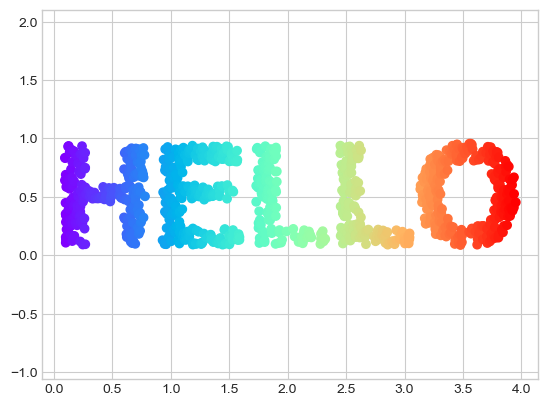

In [6]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=mpl.colormaps['rainbow'])
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

# B. Multidimensional Scaling:

* If we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same.
    * This confirms that the x and y values are not necessarily fundamental to the relationships in the data.
    * What is fundamental, in this case, is the distance between each point within the dataset.
    * A common way to represent this is to use a distance matrix: 
        * For $N$ points, we construct an $N × N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
        * This can be done using sklearn's `pairwise_distances`.

* While computing this distance matrix from $(x, y)$ coordinates is straight-forward, transforming the distances back into $x$ and $y$ coordinates is rather difficult:
    * This is exactly what the multidimensional scaling algorithm aims to do:
        * Given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data.
        * The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using only the N × N distance matrix describing the relationship between the data points.
        * The quantity preserved is the distance between every pair of points.

In [12]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    
    return np.dot(X, R)

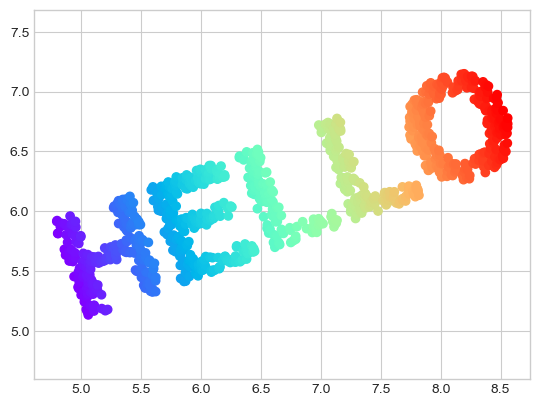

In [13]:
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [14]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X)
D.shape

(1000, 1000)

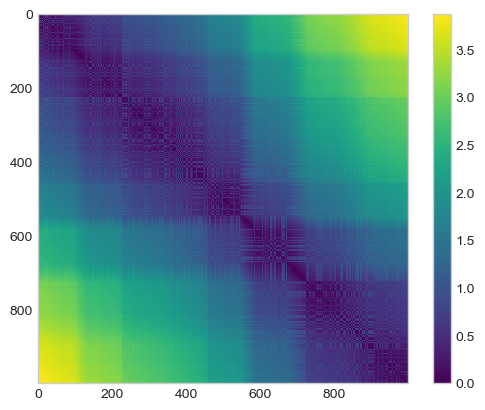

In [15]:
plt.imshow(D, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

In [16]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

c:\Users\JCA\anaconda3\envs\ds_ml_dl\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


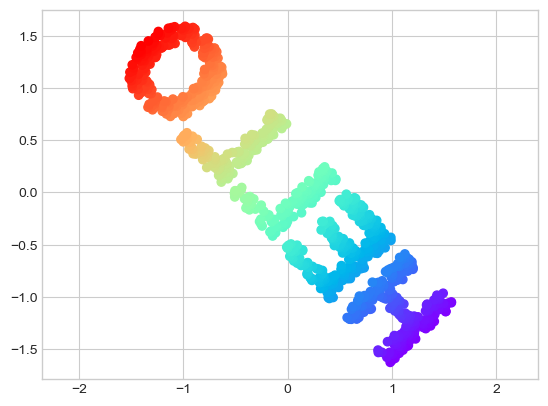

In [17]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1701)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

### B.1. MDS as Manifold Learning:

* Distance matrices can be computed from data in any dimension.

In [18]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

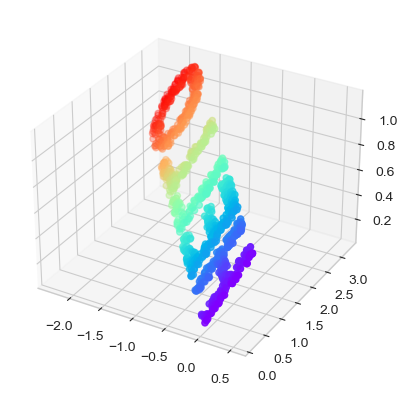

In [19]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize);

c:\Users\JCA\anaconda3\envs\ds_ml_dl\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


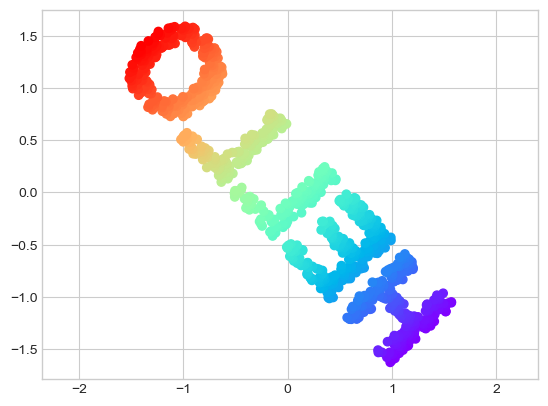

In [20]:
model = MDS(n_components=2, random_state=1701)
out3 = model.fit_transform(X3)

plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

### B.2. Nonelinear Embeddings: 

* Where MDS breaks down is when the embedding is nonlinear - when it goes beyond rotation, translation or scaling. It fails to recover the underlying structure.

In [21]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T
    
XS = make_hello_s_curve(X)

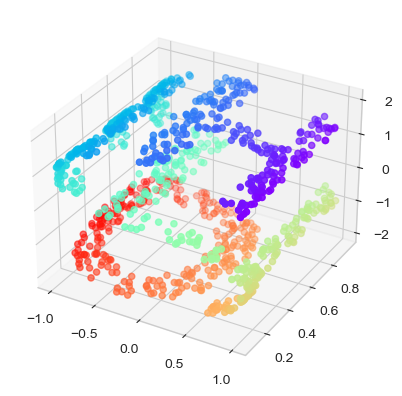

In [22]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

c:\Users\JCA\anaconda3\envs\ds_ml_dl\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


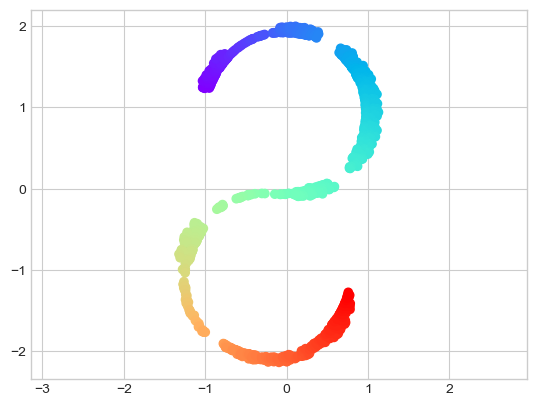

In [23]:
# Try a simple MDS algorithm on the data

model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)

plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

# C. Nonlinear Manifolds: Locally Linear Embedding

* The problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby points?:
    * Locally Linear Embedding (LLE):
        * Rather than preserving all distances, it instead tries to preserve only the distances between neighboring points (in this case, the nearest 100 neighbors of each point).

* LLE comes in a number of flavers.
    * Modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds w/ very little distortion.

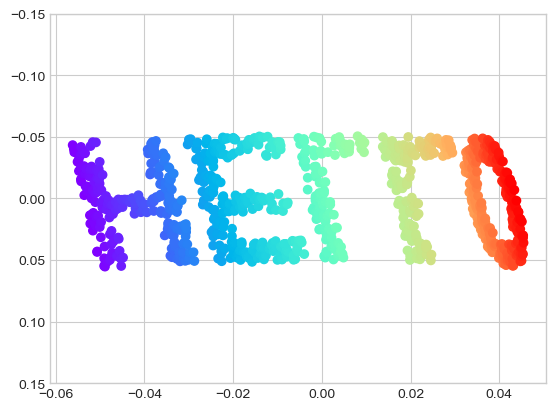

In [24]:
from sklearn.manifold import LocallyLinearEmbedding

model = LocallyLinearEmbedding(
            n_neighbors=100, 
            n_components=2,
            method='modified', 
            eigen_solver='dense')

out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

# D. Manifold Methods:

* In practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative
visualization of high-dimensional data.

* Challenges of Manifold Learning VS. PCA:
    * In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for dealing with missing data in PCA.
    * In manifold learning, the presence of noise in the data can “short-circuit” the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
    * The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
    * In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the number of output dimensions based on the explained variance.
    * In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
    * In manifold learning, the computational expense of manifold methods scales as $\mathcal{O}(N^2)$  or  $\mathcal{O}(N^3)$ . For PCA, there exist randomized approaches that are generally much faster.

* Advantages of Manifold Learning:
    * For high-dimensional data from real-world sources, LLE often produces poor results, and Isomap seems to generally lead to more meaningful embeddings. This is implemented in `sklearn.manifold.Isomap`.
    * For data that is highly clustered, t-distributed stochastic neighbor embedding (t- SNE) seems to work very well, though it can be very slow compared to other methods. This is implemented in `sklearn.manifold.TSNE`.

* Explore data w/ manifold methods only after first exploring it w/ PCA. (For nonlinear Relationships)

# E. Examples

### E.1. `isomap` on Faces:

* One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
    * A common case of high-dimensional data is images: 
        * For example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions, with the brightness of each pixel in each image defining the coordinate in that dimension.

In [25]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

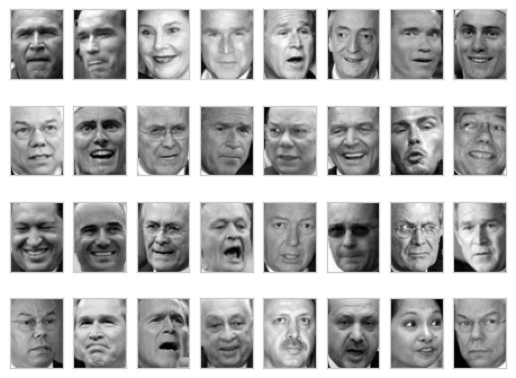

In [26]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

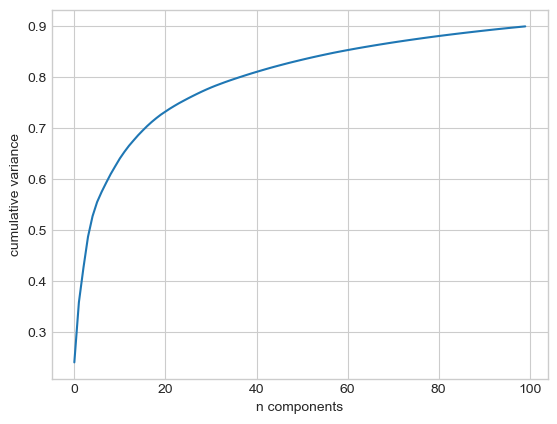

In [27]:
from sklearn.decomposition import PCA

model = PCA(100, svd_solver='randomized').fit(faces.data)

plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [28]:
from sklearn.manifold import Isomap

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [29]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    proj = model.fit_transform(data)

    ax = ax or plt.gca()
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])

        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=cmap), proj[i])
            ax.add_artist(imagebox)


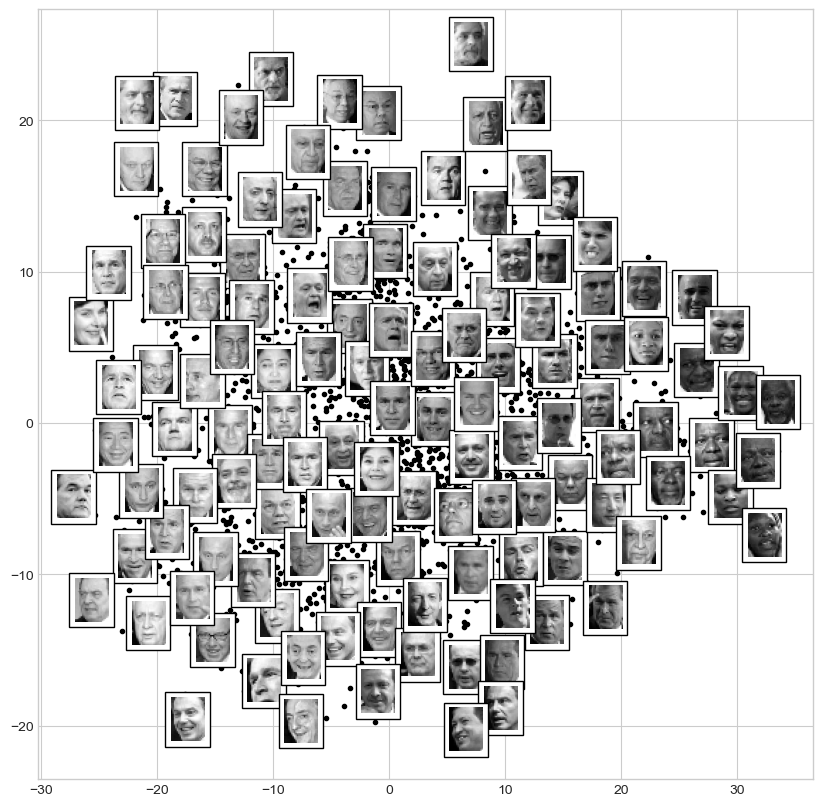

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])